# Regression Inference to Predict Snowy Plover Bird Weight from Egg Weight

In [31]:
import numpy as np
from datascience import *
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
import warnings
warnings.simplefilter('ignore', FutureWarning)

## Finding the Bootstrap Confidence Interval for the True Slope

The [Snowy Plover](https://www.audubon.org/field-guide/bird/snowy-plover) is a tiny bird that lives on the coast in parts of California and elsewhere.  It is considered endangered in many parts of the U.S. Each row of the "birds" table corresponds to one Snowy Plover egg and the resulting chick. The data was collected at the Point Reyes National Seashore.

- `Egg Length` and `Egg Breadth` (widest diameter) are measured in millimeters
- `Egg Weight` and `Bird Weight` are measured in grams; for comparison, a standard paper clip weighs about one gram

Looking at the scatter plot of our data, we observe a linear relationship between egg weight and bird weight. However, relationships that appear in a sample might not exist in the population from which the sample was taken. We want to know if there **truly** exists a linear relationship between egg weight and bird weight for Snowy Plovers. 

**First, we establish our goal: to quantify our degree of uncertaintly regarding the true slope of the regression line that predicts `Bird Weight` from `Egg Weight`.  This will allow us to evaluate the probability that there truly exists a linear relationship between egg weight and bird weight for Snowy Plovers.**

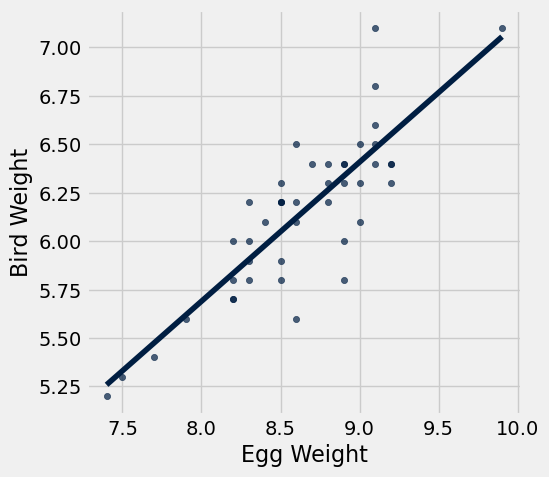

In [32]:
birds = Table.read_table('snowy_plover.csv')
birds.scatter('Egg Weight', "Bird Weight", fit_line=True)

### Fitting a Regression Line to the Sample

**Second, we plot the regression line that predicts `Bird Weight` from `Egg Weight`.**

`standard_units`: takes an array of numbers and returns an array containing those numbers converted to standard units

`correlation`: takes a table and two column names (one for *x*; one for *y*) and returns the correlation between these columns

`fit_line`: takes a table and two column names; returns an array containing the slope and intercept of the regression line (in that order)

In [33]:
def standard_units(arr):
    "Convert any array of integers and/or floats to standard units."
    return (arr - np.mean(arr))/np.std(arr)  

def correlation(tbl, x_col, y_col):
    "Return the correlation between x_col and y_col columns in a table"
    x_standard_units = standard_units(tbl.column(x_col))
    y_standard_units = standard_units(tbl.column(y_col))
    return np.mean(x_standard_units * y_standard_units)

def fit_line(tbl, x_col, y_col):
    "Return an array of the slope and intercept of the regression line that predicts y_col using x_col"
    r = correlation(tbl, x_col, y_col)
    slope = r * np.std(tbl.column(y_col)) / np.std(tbl.column(x_col))
    intercept = np.average(tbl.column(y_col)) - slope * np.average(tbl.column(x_col))
    return make_array(slope, intercept)

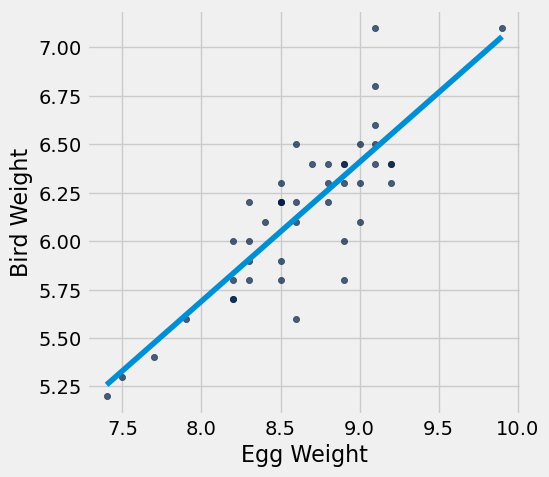

In [34]:
slope, intercept = fit_line(birds, "Egg Weight", "Bird Weight")
birds.scatter("Egg Weight", "Bird Weight")
plt.plot([min(birds.column("Egg Weight")), max(birds.column("Egg Weight"))], 
         [slope*min(birds.column("Egg Weight"))+intercept, slope*max(birds.column("Egg Weight"))+intercept])
plt.show()

### Defining a Null Hypothesis

**Third, we create a null hypothesis and an alternative hypothesis.**

If there is no linear relationship between the two variables, then we'd expect a correlation of 0. Consequently, the slope of the regression line would also be 0. 

- **Null Hypothesis:** There is no linear relationship between egg and chick weight (slope of regression line == 0).
- **Alternative Hypothesis:** There is a linear relationship between egg and chick weight (slope of regression line == 0).

### Bootstrapping the Sample

**Fourth, we plot a histogram of  `resampled_slopes`: an array that contains the slope of the regression  for 1000 bootstrap resamples of `birds`**

In the context of regression inference, bootstrapping refers to a resampling technique that is used to estimate the uncertainty associated with the regression model's coefficients. The idea is to create multiple bootstrap samples by randomly sampling from the original dataset with replacement. Each bootstrap sample is the same size as the original dataset but may contain duplicate observations. By generating multiple bootstrap samples, you can simulate a large number of "pseudo-populations."

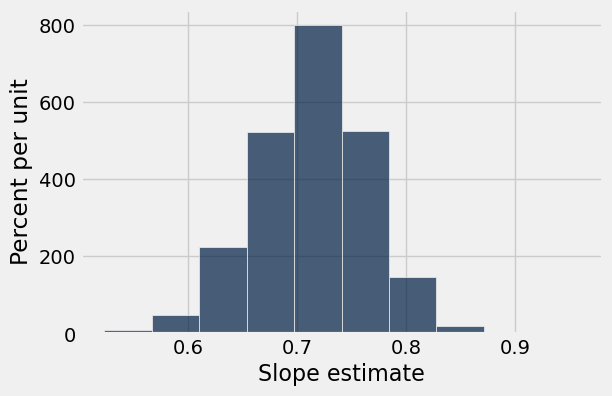

In [35]:
resample_slopes =  make_array()

for i in np.arange(1000): 
    birds_resample = birds.sample()
    resample_line = fit_line(birds_resample,"Egg Weight", "Bird Weight")
    resample_slope = resample_line[0]
    resample_slopes = np.append(resample_slopes, resample_slope)

Table().with_column("Slope estimate", resample_slopes).hist()

### Computing  a Confidence Interval for the True Slope

**Fifth, we create a 95% confidence interval that quantifies our uncertainty about the true relationship between egg and bird weight.**

Note that a 95% confidence interval is a statistical tool that, in context, indicates that if you were to repeat the sampling process numerous times using the same method, approximately 95% of the resulting intervals would encompass the true population parameter. The reason a 95% confidence interval is commonly used is because it provides a range of plausible values for the population parameter, derived from the sample data, that allows for reliable statistical inference.

In [36]:
lower_end = percentile(2.5, resample_slopes)
upper_end = percentile(97.5, resample_slopes)
print("95% confidence interval for slope: [{:g}, {:g}]".format(lower_end, upper_end))

95% confidence interval for slope: [0.608676, 0.8079]


### Evaluating the Null Hypothesis

Recall that we have followed the following procedure to get to this point:

1. Define a null and alternative hypothesis. (ex. "The parameter is X" or "The parameter is not X.")
2. Construct a confidence interval using bootstrap sampling.

Now we'll decide to accept or reject the null hypothesis:

3. Using the confidence interval, determine if the data is more consistent with the null or alternative hypothesis:
   * If the null hypothesis mean (X) is in the confidence interval, the data is more consistent with the null hypothesis.
   * If the null hypothesis mean (X) is *not* in the confidence interval, the is are more consistent with the alternative hypothesis.
   
**Looking at our confidence interval, it does not contain 0. Therefore, we reject the null hypothesis.**

## Finding the Bootstrap Prediction Interval

The function `fitted_value` takes four arguments:

1. `table`: a table like `birds`.  We'll be predicting the values in the second column using the first.
2. `x_col`: the name of our x-column within the input `table`
3. `y_col`: the name of our y-column within the input `table`
2. `given_x`: a number, the value of the predictor variable for which we'd like to make a prediction.
  
It returns the regression line’s prediction for the given x.

In [37]:
def fitted_value(table, x_col, y_col, given_x):
    line = fit_line(table, x_col, y_col)
    slope = line[0]
    intercept = line[1]
    return slope*given_x + intercept

The function `compute_resampled_line` function takes three arguments:
1. A table `tbl`
2. Two column names, `x_col` and `y_col`

It returns an array containing the parameters of the best fit line (slope and intercept) for one bootstrapped resample of the table.

In [38]:
def compute_resampled_line(tbl, x_col, y_col):
    resample = tbl.sample()
    resampled_line = fit_line(resample, x_col, y_col)
    return resampled_line

The function `bootstrap_lines` takes in four arguments:
1. `tbl`: a table like `birds`
2. `x_col`: the name of our x-column within the input `tbl`
3. `y_col`: the name of our y-column within the input `tbl`
4. `num_bootstraps`: an integer, a number of bootstraps to run.

It returns a *table* with one row for each bootstrap resample and the following two columns:
1. `Slope`: the bootstrapped slopes 
2. `Intercept`: the corresponding bootstrapped intercepts 

In [39]:
def bootstrap_lines(tbl, x_col, y_col, num_bootstraps):
    resampled_slopes = make_array()
    resampled_intercepts = make_array() 
    for i in np.arange(num_bootstraps): 
        resampled_line = compute_resampled_line(tbl, x_col, y_col) 
        resampled_slope = resampled_line.item(0) 
        resampled_intercept = resampled_line.item(1) 
        resampled_slopes = np.append(resampled_slopes,resampled_slope)
        resampled_intercepts = np.append(resampled_intercepts,resampled_intercept)
    tbl_lines = Table().with_columns('Slope', resampled_slopes, 'Intercept', resampled_intercepts)
    return tbl_lines

**We can use these functions to create a bootstrap confidence interval for the true value of the mean bird's weight for an egg of `x` grams.**

For example, let's create a bootstrap confidence interval for the true value of the mean bird's weight for an egg of 9 grams:

In [40]:
predictions_for_nine = make_array()

for idx in np.arange(regression_lines.num_rows):
    
    slope = regression_lines.column("Slope").item(idx)
    intercept = regression_lines.column("Intercept").item(idx)
    prediction_for_nine = slope * 9 + intercept
    predictions_for_nine = np.append(predictions_for_nine, prediction_for_nine)

lower_end_pred = percentile(2.5, predictions_for_nine)
upper_end_pred = percentile(97.5, predictions_for_nine)

print("95% confidence interval for mean bird weight for a 9 gram egg:")
print("[{:g}, {:g}]".format(lower_end_pred, upper_end_pred))

95% confidence interval for mean bird weight for a 9 gram egg:
[6.32034, 6.5017]
